<div dir="rtl" style="color:red; font-size:1.2em; font-weight:bold; text-align:center;">
قبل از اجرای این فاز، گرفتن خروجی از فاز ۲ پروژه الزامی است.
</div>


# Phase 4: Uncertainty Estimation & Sales Classification

## Project Overview
In this phase, we move beyond simple point forecasting. We aim to provide a more comprehensive analysis of future sales by:
1.  **Sales Classification:** Categorizing daily sales into 'Low', 'Medium', and 'High' classes.
2.  **Uncertainty Estimation:** Predicting the range of sales (confidence intervals) using Quantile Regression.
3.  **Multi-step Forecasting:** Implementing a recursive strategy to predict sales for the next 7 days.

## 1. Environment Setup & Data Loading
We load the pre-processed data (Pickle files) generated in Phase 2.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc  # Garbage Collection for memory management
import os

# Machine Learning Libraries
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelBinarizer
import lightgbm as lgb

# Plotting Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
# CHANGE THIS PATH to the exact location of your .pkl files
# Based on your image, it might be: 'Archive/data/phase2_output/pkl'
BASE_PATH = '../data/phase2_output/pkl' 

print(f"Working Directory: {os.getcwd()}")
print(f"Data Path: {BASE_PATH}")


Working Directory: c:\Users\USER\Desktop\ML_project\solution
Data Path: ../data/phase2_output/pkl


In [41]:
def load_data(base_path):
    """
    Loads train and validation data from pickle files.
    """
    try:
        print("Loading Train Split...")
        train_df = pd.read_pickle(os.path.join(base_path, 'train_split.pkl'))
        
        print("Loading Validation Split...")
        val_df = pd.read_pickle(os.path.join(base_path, 'val_split.pkl'))
        
        # Define features to use for modeling
        # We must exclude the target ('Sales'), Date, and future-unknowns like 'Customers'
        ignore_cols = ['Date', 'Sales', 'Customers', 'Sales_Class'] 
        feature_cols = [c for c in train_df.columns if c not in ignore_cols]
        
        print(f"Data Loaded Successfully.")
        print(f"Train Shape: {train_df.shape}")
        print(f"Val Shape:   {val_df.shape}")
        print(f"Num Features: {len(feature_cols)}")
        
        return train_df, val_df, feature_cols
        
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Load the data
train_df, val_df, feature_cols = load_data(BASE_PATH)

# MEMORY OPTIMIZATION
# Convert object columns to category to save RAM
if train_df is not None:
    for col in train_df.select_dtypes(include=['object']).columns:
        train_df[col] = train_df[col].astype('category')
        val_df[col] = val_df[col].astype('category')

    gc.collect()
else:
    print("STOP: Fix the data path before proceeding.")


Loading Train Split...
Loading Validation Split...
Data Loaded Successfully.
Train Shape: (794209, 94)
Val Shape:   (103695, 94)
Num Features: 91


## 2. Sales Classification

### Objective
Instead of predicting the exact sales number, we classify the daily sales volume into three categories:
- **Low (Class 0):** Sales < 33rd percentile
- **Medium (Class 1):** 33rd percentile ≤ Sales < 66th percentile
- **High (Class 2):** Sales ≥ 66th percentile

### Methodology
1.  Calculate thresholds using the **Training Set** only.
2.  Create a target variable `Sales_Class`.
3.  Train a **LightGBM Classifier**.
4.  Evaluate using **ROC-AUC** (One-vs-Rest) and **F1-Score**.


In [42]:
# 1. Calculate Quantiles on Training Data
# We use only training data to avoid data leakage
q33 = train_df['Sales'].quantile(0.33)
q66 = train_df['Sales'].quantile(0.66)

print(f"Thresholds determined from Train Data:")
print(f"Low/Medium Boundary (33%): {q33:.2f}")
print(f"Medium/High Boundary (66%): {q66:.2f}")

# 2. Function to map sales to classes
def classify_sales(sales_value):
    if sales_value < q33:
        return 0 # Low
    elif sales_value < q66:
        return 1 # Medium
    else:
        return 2 # High

# 3. Apply to Train and Validation
print("\nGenerating 'Sales_Class' labels...")
train_df['Sales_Class'] = train_df['Sales'].apply(classify_sales)
val_df['Sales_Class'] = val_df['Sales'].apply(classify_sales)

# Verify Class Distribution
print("Train Class Distribution:")
print(train_df['Sales_Class'].value_counts(normalize=True))


Thresholds determined from Train Data:
Low/Medium Boundary (33%): 4432.00
Medium/High Boundary (66%): 6942.00

Generating 'Sales_Class' labels...
Train Class Distribution:
Sales_Class
2    0.340065
0    0.329969
1    0.329966
Name: proportion, dtype: float64


In [43]:
import re

print("Preparing data for LightGBM Classifier...")

# Create copies to avoid modifying the original dataframes
X_train = train_df[feature_cols].copy()
y_train = train_df['Sales_Class']

X_val = val_df[feature_cols].copy()
y_val = val_df['Sales_Class']

# --- BUG FIX: Remove special characters from column names ---
# LightGBM does not support , [ ] { } " : in column names.
clean_columns = {col: re.sub(r'[",\[\]{}:]', '_', col) for col in X_train.columns}
X_train.rename(columns=clean_columns, inplace=True)
X_val.rename(columns=clean_columns, inplace=True)
# ------------------------------------------------------------

# Define the LightGBM Classifier
clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    n_estimators=100,      
    learning_rate=0.1,
    max_depth=10,
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    verbose=-1             # Suppress warnings
)

print("Training Model (this may take 1-2 minutes)...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(20)]
)

print("Training Finished.")


Preparing data for LightGBM Classifier...
Training Model (this may take 1-2 minutes)...
Training until validation scores don't improve for 10 rounds
[20]	valid_0's multi_logloss: 0.356756
[40]	valid_0's multi_logloss: 0.287159
[60]	valid_0's multi_logloss: 0.272161
[80]	valid_0's multi_logloss: 0.266092
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.264676
Training Finished.


Generating Predictions on Validation Set...

--- Classification Report ---
              precision    recall  f1-score   support

         Low       0.93      0.91      0.92     31474
      Medium       0.83      0.87      0.85     36102
        High       0.92      0.90      0.91     36119

    accuracy                           0.89    103695
   macro avg       0.89      0.89      0.89    103695
weighted avg       0.89      0.89      0.89    103695

Weighted F1 Score: 0.8907
Weighted ROC-AUC Score: 0.9767


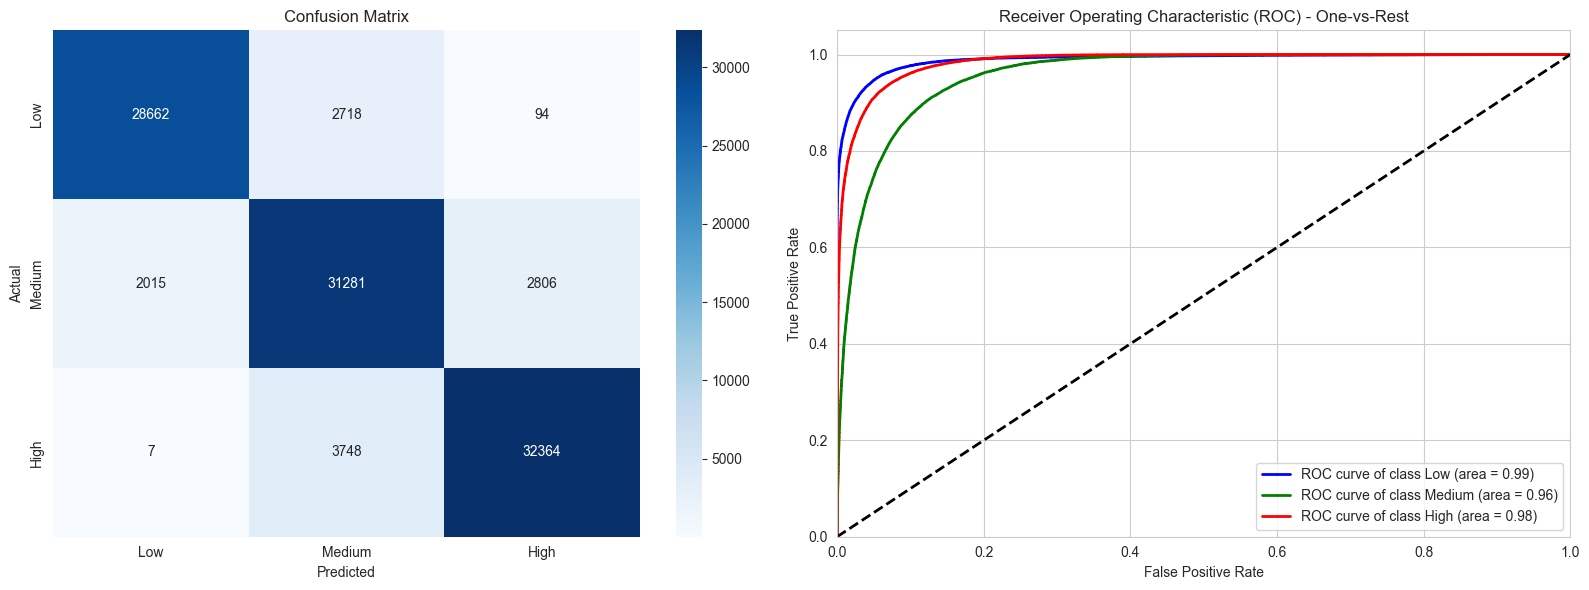

7972

In [44]:
print("Generating Predictions on Validation Set...")
y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val) # Probability estimates for ROC-AUC

# 1. Classification Report (F1-Score, Precision, Recall)
print("\n--- Classification Report ---")
print(classification_report(y_val, y_pred, target_names=['Low', 'Medium', 'High']))

# 2. Weighted F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# 3. ROC-AUC Score (One-vs-Rest strategy for multiclass)
# We need to binarize labels to calculate AUC for each class
lb = LabelBinarizer()
lb.fit(y_val)
y_val_bin = lb.transform(y_val)

roc_auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

# ---------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# A) Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], 
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# B) ROC Curve for each class
from sklearn.metrics import roc_curve, auc

colors = ['blue', 'green', 'red']
classes = ['Low', 'Medium', 'High']

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc_i = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc_i:.2f})')

ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Clean up memory before next step
del X_train, y_train, X_val, y_val, y_pred, y_pred_proba
gc.collect()


## 3. Uncertainty Estimation (Quantile Regression)

### Objective
Instead of providing a single deterministic point forecast, we estimate the prediction intervals. We want to be able to say: *"We are 80% confident that tomorrow's sales will be between X and Y."*

### Methodology
We will train three separate LightGBM models using the `quantile` objective:
1.  **Lower Bound (10th Percentile - $\alpha = 0.1$):** 10% probability that actual sales will be lower.
2.  **Median Forecast (50th Percentile - $\alpha = 0.5$):** The central point forecast.
3.  **Upper Bound (90th Percentile - $\alpha = 0.9$):** 10% probability that actual sales will be higher.

This creates an 80% Prediction Interval. We will evaluate it using the **Coverage Ratio** (how often the actual sales fall within our predicted bounds).


In [46]:
# 1. Prepare Data for Quantile Regression
# We need the original 'Sales' target, not the classes
print("Preparing data for Quantile Regression...")

X_train_qr = train_df[feature_cols].copy()
y_train_qr = train_df['Sales']

X_val_qr = val_df[feature_cols].copy()
y_val_qr = val_df['Sales']

# Bug Fix from earlier: Clean column names for LightGBM
clean_columns_qr = {col: re.sub(r'[",\[\]{}:]', '_', col) for col in X_train_qr.columns}
X_train_qr.rename(columns=clean_columns_qr, inplace=True)
X_val_qr.rename(columns=clean_columns_qr, inplace=True)

# Define quantiles for an 80% prediction interval
quantiles = [0.10, 0.50, 0.90]
models = {}
predictions = {}

print("Training Quantile Models...")

# 2. Train a separate model for each quantile
for alpha in quantiles:
    print(f"\n--- Training Model for Quantile: {alpha} ---")
    
    # Define Regressor with 'quantile' objective
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # Fit the model
    model.fit(
        X_train_qr, y_train_qr,
        eval_set=[(X_val_qr, y_val_qr)],
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)] # Silent eval
    )
    
    models[alpha] = model
    
    # Predict on validation set
    predictions[alpha] = model.predict(X_val_qr)
    print(f"Finished training for alpha={alpha}")

# 3. Create a DataFrame for the results
results_df = pd.DataFrame({
    'Actual_Sales': y_val_qr.values,
    'Lower_Bound_10': predictions[0.10],
    'Median_Forecast_50': predictions[0.50],
    'Upper_Bound_90': predictions[0.90]
})

print("\nModels trained and predictions generated successfully.")


Preparing data for Quantile Regression...
Training Quantile Models...

--- Training Model for Quantile: 0.1 ---
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's quantile: 118.223
Finished training for alpha=0.1

--- Training Model for Quantile: 0.5 ---
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's quantile: 264.922
Finished training for alpha=0.5

--- Training Model for Quantile: 0.9 ---
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's quantile: 132.639
Finished training for alpha=0.9

Models trained and predictions generated successfully.


Target Coverage Ratio: 80.00%
Actual Coverage Ratio Achieved: 83.30%

Number of stores in validation set: 1115
Plotting data for Store ID: -0.9982078853046595


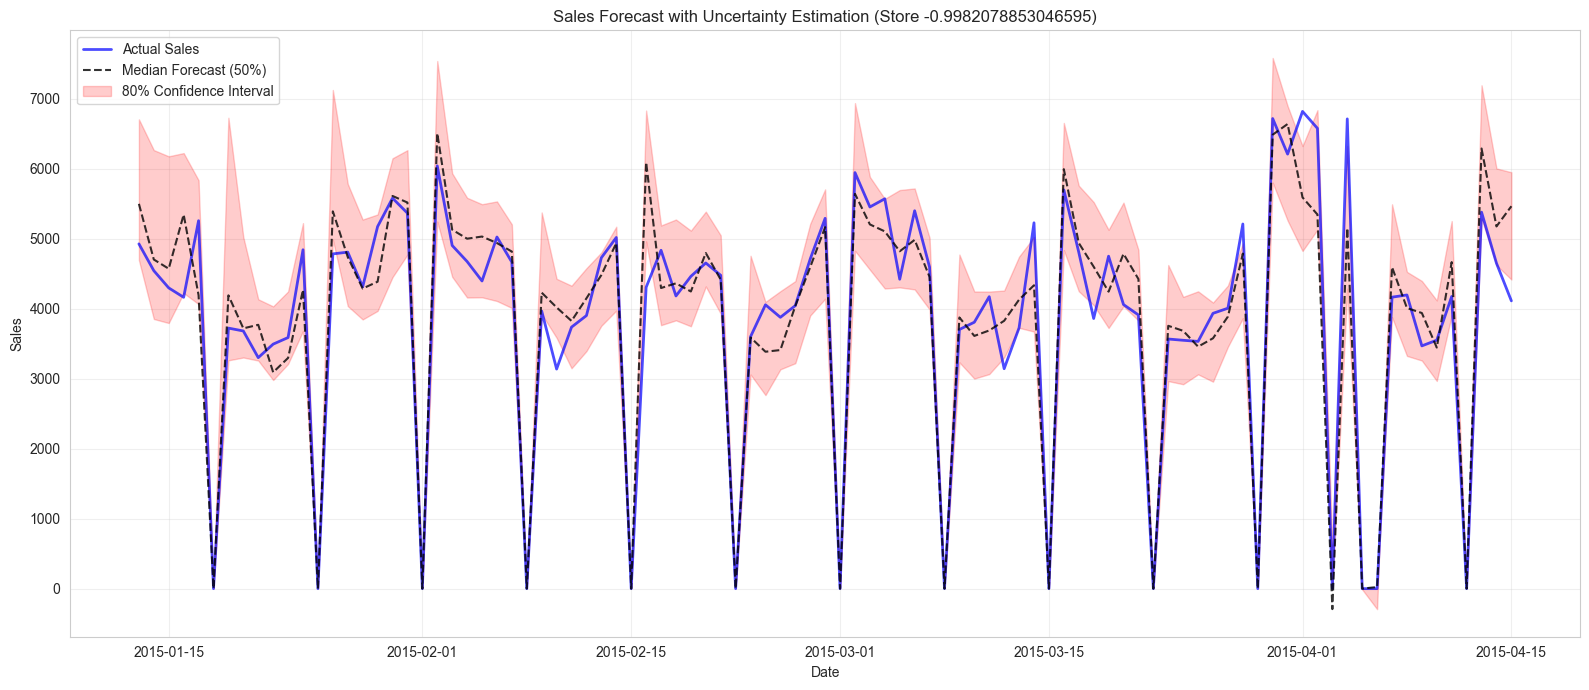


Sample Data for this store:


,Store,Date,Actual_Sales,Lower_Bound_10,Median_Forecast_50,Upper_Bound_90,is_covered
0,-0.998208,2015-01-13,4924,4691.868322,5495.841765,6702.869781,True
1,-0.998208,2015-01-14,4541,3851.054295,4700.556572,6263.313649,True
2,-0.998208,2015-01-15,4295,3793.626340,4569.282795,6174.538808,True
3,-0.998208,2015-01-16,4161,4222.068267,5342.483601,6220.545554,False
4,-0.998208,2015-01-17,5255,4063.563626,4190.698803,5832.623434,True


3770

In [47]:
# 4. Evaluate Uncertainty: Calculate Coverage Ratio
results_df['is_covered'] = (results_df['Actual_Sales'] >= results_df['Lower_Bound_10']) & \
                           (results_df['Actual_Sales'] <= results_df['Upper_Bound_90'])

coverage_ratio = results_df['is_covered'].mean()
print(f"Target Coverage Ratio: 80.00%")
print(f"Actual Coverage Ratio Achieved: {coverage_ratio * 100:.2f}%")

# --- ROBUST VISUALIZATION FIX ---

# 1. Align val_df metadata with results
# We reset index of val_df to match results_df (which is 0-based)
val_meta = val_df[['Store', 'Date']].reset_index(drop=True)
plot_df = pd.concat([val_meta, results_df], axis=1)

# 2. Automatically pick a store that exists in the validation set
available_stores = plot_df['Store'].unique()
print(f"\nNumber of stores in validation set: {len(available_stores)}")

if len(available_stores) > 0:
    # Pick the first available store
    store_to_plot = available_stores[0] 
    print(f"Plotting data for Store ID: {store_to_plot}")

    # 3. Filter and Sort
    store_data = plot_df[plot_df['Store'] == store_to_plot].sort_values('Date')

    # 4. Plot
    plt.figure(figsize=(16, 7))
    plt.plot(store_data['Date'], store_data['Actual_Sales'], label='Actual Sales', color='blue', linewidth=2, alpha=0.7)
    plt.plot(store_data['Date'], store_data['Median_Forecast_50'], label='Median Forecast (50%)', color='black', linestyle='--', alpha=0.8)

    # Fill the area (Uncertainty)
    plt.fill_between(store_data['Date'], 
                     store_data['Lower_Bound_10'], 
                     store_data['Upper_Bound_90'], 
                     color='red', alpha=0.2, label='80% Confidence Interval')

    plt.title(f'Sales Forecast with Uncertainty Estimation (Store {store_to_plot})')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Show first few rows to confirm data exists
    print("\nSample Data for this store:")
    display(store_data.head())
    
else:
    print("Error: No stores found in the merged dataframe. Check val_df indices.")

import gc
gc.collect()


## 4. Multi-step Forecasting (Standard Regression)

### Objective
The final step in Phase 4 is to generate deterministic multi-step forecasts for the hold-out test set (the last 10% of our chronological data) and evaluate our model's pure predictive performance across multiple future time steps.

### Methodology
We will use a standard `LGBMRegressor` optimized for Mean Squared Error (MSE), but we will evaluate it using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the `test_split`.


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import re
import lightgbm as lgb

print("Loading Test Set for Multi-step Forecasting...")
base_path = '../data/phase2_output/pkl'
test_df = pd.read_pickle(f'{base_path}/test_split.pkl')

# 1. First extract the features and target using original names
X_test = test_df[feature_cols].copy()
y_test = test_df['Sales']

# 2. THEN clean column names for LightGBM
clean_columns_test = {col: re.sub(r'[",\[\]{}:]', '_', col) for col in X_test.columns}
X_test.rename(columns=clean_columns_test, inplace=True)

print("Training final Multi-step Forecasting Model...")

# 3. Train a standard LightGBM Regressor
forecast_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train model
forecast_model.fit(
    X_train_qr, y_train_qr, 
    eval_set=[(X_val_qr, y_val_qr)],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(50)]
)

# 4. Predict on the ENTIRE Test Set
print("\nGenerating forecasts for the Test Set...")
y_pred = forecast_model.predict(X_test)

# 5. Evaluate Metrics (Filter only open days based on actual Sales > 0)
# This bypasses the scaled 'Open' column issue perfectly
eval_mask = y_test > 0
y_test_eval = y_test[eval_mask]
y_pred_eval = y_pred[eval_mask]

mae = mean_absolute_error(y_test_eval, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
mean_sales = y_test_eval.mean()
wmape = (mae / mean_sales) * 100

print(f"\n--- Forecasting Performance on Open Days (Test Set) ---")
print(f"MAE (Mean Absolute Error) : {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"WMAPE (Weighted MAPE)     : {wmape:.2f}%")


Loading Test Set for Multi-step Forecasting...
Training final Multi-step Forecasting Model...
Training until validation scores don't improve for 20 rounds
[50]	valid_0's l2: 957537
[100]	valid_0's l2: 710838
[150]	valid_0's l2: 687759
[200]	valid_0's l2: 672693
[250]	valid_0's l2: 661979
[300]	valid_0's l2: 653416
[350]	valid_0's l2: 647545
[400]	valid_0's l2: 644370
[450]	valid_0's l2: 642493
[500]	valid_0's l2: 640679
Did not meet early stopping. Best iteration is:
[488]	valid_0's l2: 640549

Generating forecasts for the Test Set...

--- Forecasting Performance on Open Days (Test Set) ---
MAE (Mean Absolute Error) : 571.39
RMSE (Root Mean Squared Error): 810.15
WMAPE (Weighted MAPE)     : 7.92%


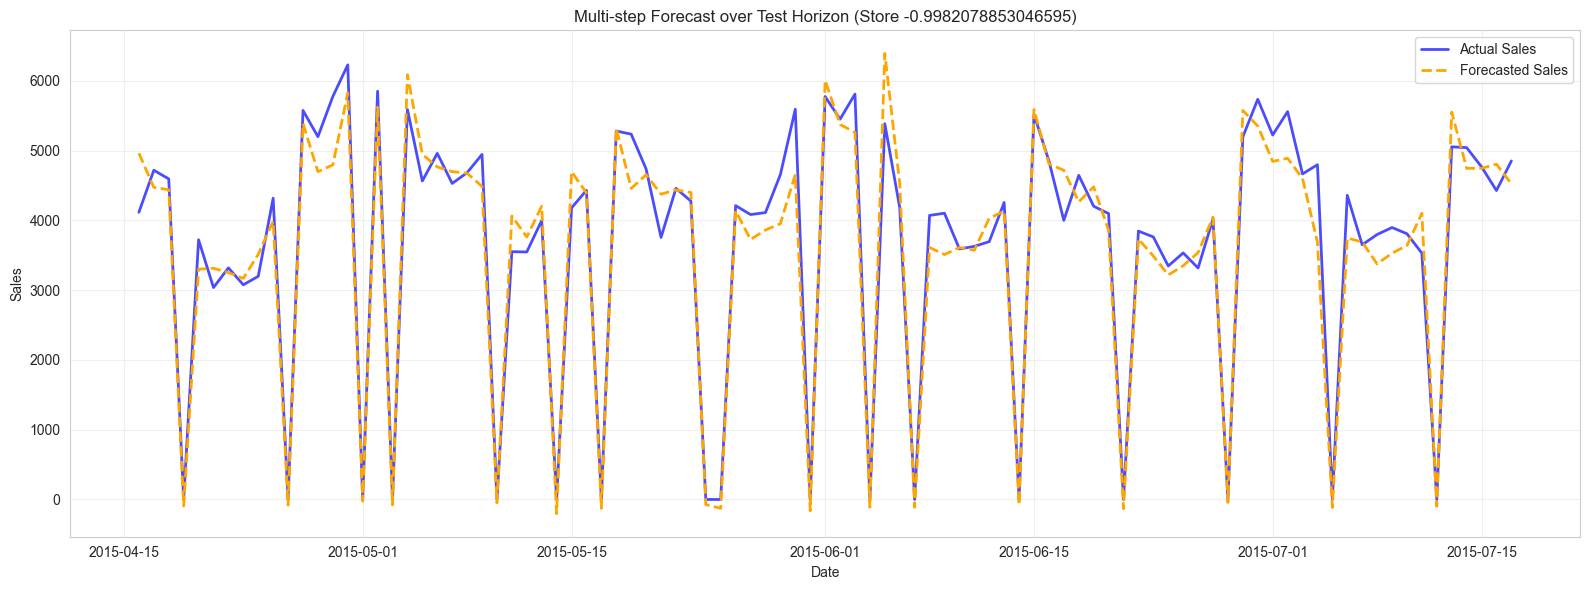

In [35]:
# 4. Visualize Multi-step Forecast for a specific store
# Find a store that has sales in the test set
test_stores = test_df[test_df['Sales'] > 0]['Store'].unique()
store_to_forecast = test_stores[0] # Pick the first available

# Filter data for plotting
plot_mask = (test_df['Store'] == store_to_forecast)
store_dates = test_df.loc[plot_mask, 'Date']
actual_sales_plot = test_df.loc[plot_mask, 'Sales']

# Predict for all days
X_test_store = X_test[plot_mask] # X_test is already cleaned
pred_sales_plot = forecast_model.predict(X_test_store)

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(store_dates, actual_sales_plot, label='Actual Sales', color='blue', alpha=0.7, linewidth=2)
plt.plot(store_dates, pred_sales_plot, label='Forecasted Sales', color='orange', linestyle='--', linewidth=2)

plt.title(f'Multi-step Forecast over Test Horizon (Store {store_to_forecast})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
